In [1]:
import random
from numpy.random import seed
seed(3)
import numpy as np
np.random.default_rng
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import read_csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from os.path import expanduser as ospath
import time

import xgboost as xgb
from sklearn.model_selection import KFold,GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
import gensim

# 1. Load data set with cleaned text

In [2]:
with open(ospath('~/final_project/B_Data_pre_processing/Pickle_Files/Claims_cleaned.pickle'), 'rb') as data:
    db = pickle.load(data)

In [3]:
db.head()

,publn_nr,type,label,text,text_clean
1,4254843,Claim 1,product,An electrically powered vehicle comprising: a ...,electrically power vehicle comprise body suppo...
2,4254843,Claim 2,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
3,4254843,Claim 3,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim wherei...
4,4254843,Claim 4,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...
5,4254843,Claim 5,product,An electrically powered vehicle as recited in ...,electrically power vehicle recite claim compri...


In [4]:
db.groupby(by='label').count()

,publn_nr,type,text,text_clean
label,,,,
process,740,740,740,740
product,3809,3809,3809,3809
product and process,1,1,1,1
use claim,307,307,307,307


This convert name labels form string to numbers and merge into only two classes 

In [5]:
db['label'] = db.label.replace(to_replace=['process', 'product','use claim'], value=[0, 1, 2])

I delete the only claim labelled as product by process

In [6]:
db = db[(db['label'] != 'product and process')]

In [7]:
db.groupby(by='label').count()

,publn_nr,type,text,text_clean
label,,,,
0,740,740,740,740
1,3809,3809,3809,3809
2,307,307,307,307


## 2. Split the dataset by patents into train, validation and test datasets 

In [8]:
def split_train_test_val(db):
    
    random.seed(2)
    pat_nr = list(db['publn_nr'].unique())
    print('number of patents :',str(len(pat_nr )))
    
    test =  random.sample(pat_nr, 48)

    train_test = [i for i in pat_nr if i not in test]

    val = random.sample(train_test, 48)

    train = [i for i in train_test if i not in val]

    #create an empty data set
    train_db = pd.DataFrame()                             
    for num in range(len(train)):   
        train_db = train_db.append(db.loc[db['publn_nr'] == train[num]], ignore_index=True)

    #create an empty data set
    val_db = pd.DataFrame()                             
    for num in range(len(val)):   
        val_db = val_db.append(db.loc[db['publn_nr'] == val[num]], ignore_index=True)

    #create an empty data set
    test_db = pd.DataFrame()                             
    for num in range(len(test)):   
        test_db = test_db.append(db.loc[db['publn_nr'] == test[num]], ignore_index=True)

    print('-'*80,'\n')
    print('Train data:')
    print('Train data shape: {} \nNumber of patents: {}'.format(train_db.shape ,len(train_db['publn_nr'].unique())))
    print('First patent number train:',train_db['publn_nr'].iloc[0])
    print()
    print('Train frequency classes:',train_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Test data:')
    print('Test data shape: {} \nNumber of patents: {}'.format(test_db.shape, len(test_db['publn_nr'].unique())))
    print('First patent number test:',test_db['publn_nr'].iloc[0])
    print()
    print('Test frequency classes:',test_db.groupby(by='label').count().iloc[:,:1])
    print('-'*80,'\n')
    print('Val data:')
    print('Val data shape: {} \nNumber of patents: {}'.format(val_db.shape, len(val_db['publn_nr'].unique())))
    print('First patent number val:',val_db['publn_nr'].iloc[0])
    print()
    print('Val frequency classes:',val_db.groupby(by='label').count().iloc[:,:1],'\n')
    
    
    return train_db, test_db, val_db

train_db, test_db, val_db = split_train_test_val(db) 


number of patents : 194
-------------------------------------------------------------------------------- 

Train data:
Train data shape: (2302, 5) 
Number of patents: 98
First patent number train: 4254843

Train frequency classes:        publn_nr
label          
0           292
1          1804
2           206
-------------------------------------------------------------------------------- 

Test data:
Test data shape: (1125, 5) 
Number of patents: 48
First patent number test: 6794777

Test frequency classes:        publn_nr
label          
0           254
1           831
2            40
-------------------------------------------------------------------------------- 

Val data:
Val data shape: (1429, 5) 
Number of patents: 48
First patent number val: 7058525

Val frequency classes:        publn_nr
label          
0           194
1          1174
2            61 



### Separate for the three datasets the features from the labels

In [9]:
X_train = train_db['text_clean']
y_train = train_db['label']

X_val = val_db['text_clean']
y_val = val_db['label']

X_test = test_db['text_clean']
y_test = test_db['label']

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

## 3. Load the Word2Vec model

In [10]:
model_w2v = gensim.models.Word2Vec.load(ospath('~/final_project/C_Feature_extraction/model_w2v_300_uspto_epo'))

In order to use a word2vec model trained on another text, we need to transform all the words in the new text 
in vectors and this can be done by averanging the word vectors of the word2vec model for all the words in the new text.

In [11]:
class MeanEmbeddingVectorizer(object):
    
    """This class builds the feature
    by averanging the word vectors
    for the words in the text"""
    
    def __init__(self, word2vec, dim):
        self.word2vec = word2vec
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
# reference http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

We create the new dictionary of vectors

In [12]:
w2v = {w: vec for w, vec in zip(model_w2v.wv.index2word, model_w2v.wv.syn0)}

## 4. Test harness to spot-check the best algorithms

In [13]:

#Creats the Pipeline with the two feature extractions methods for each learning alrgorithm
xgb_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),  ('XGB',xgb.XGBClassifier(objective = 'multi:softmax',num_class = 3, n_jobs =-1 ))])
xgb_model_w2v = Pipeline([("word2vec",MeanEmbeddingVectorizer(w2v,300)) , ('XGB', xgb.XGBClassifier(objective = 'multi:softmax',num_class = 3 , n_jobs =-1))])

SVM_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)) , ('SVM', SVC(random_state = 0))])
SVM_model_w2v = Pipeline([("word2vec",MeanEmbeddingVectorizer(w2v, 300)) , ('SVM', SVC(random_state = 0))])

RFC_model_tfidf = Pipeline([("tfidf", TfidfVectorizer(lowercase=False,ngram_range=(1,2), max_features=300,sublinear_tf=True)),('RFC', RandomForestClassifier(n_jobs=-1))])
RFC_model_w2v = Pipeline([("word2vec",MeanEmbeddingVectorizer(w2v, 300)),('RFC', RandomForestClassifier(random_state = 0, n_jobs=-1))])


#
models = []
models.append(('XGB_tfidf', xgb_model_tfidf))
models.append(('xgb__w2v', xgb_model_w2v))
models.append(('SVM_tfidf', SVM_model_tfidf))
models.append(('SVM_w2v', SVM_model_w2v))
models.append(('RFC_tfidf', RFC_model_tfidf))
models.append(('RFC_w2v', RFC_model_w2v))

#for the parameters scoring 
scoring_acc = metrics.make_scorer(metrics.accuracy_score)
scoring_prec = metrics.make_scorer(metrics.precision_score, average = 'macro')
scoring_rec = metrics.make_scorer(metrics.recall_score, average = 'macro')
scoring_f1 = metrics.make_scorer(metrics.f1_score, average = 'macro')

score_list = []
score_list.append(scoring_acc)
score_list.append(scoring_prec)
score_list.append(scoring_rec)
score_list.append(scoring_f1)

names_score = ['acc', 'prec', 'rec', 'f1']
name_score_model = []

#to store results of cv in a data set
results_std = []
results_mean = []
results = []

#
time_models =[]

for name, model in models:
    for score, name_score in zip(score_list, names_score):
        kfold = KFold(n_splits=10, random_state=7)
        
        #timing the model
        start = time.time()
        results_cv = cross_val_score(model, X_train, y_train, cv=kfold, scoring= score)
        end = time.time()
        
        results_mean.append(round(results_cv.mean(),5))
        results_std.append(round(results_cv.std(),5))
        results.append(results_cv)
        time_models.append(round(end - start, 5))
        name_score_model.append((name, name_score))
        
name_dict_db_results = [' '.join(map(str,name_score_model[i])) for i in range(len(name_score_model))]
dictionary_results = {'Model': name_dict_db_results, 'Mean': results_mean, 'Std': results_std, 'time_models' :time_models } 
db_results = pd.DataFrame(dictionary_results)

#Adapted from - Brownlee, J. (2016) Machine learning mastery with Python: understand your data, create accurate models, and work projects end-to-end.

### The results of the test harness are:

In [14]:
db_results

,Model,Mean,Std,time_models
0,XGB_tfidf acc,0.91311,0.06231,8.55874
1,XGB_tfidf prec,0.67302,0.17445,7.36731
2,XGB_tfidf rec,0.63797,0.18511,7.51093
3,XGB_tfidf f1,0.62705,0.18463,7.56578
4,xgb__w2v acc,0.77879,0.09090,117.84614
5,xgb__w2v prec,0.49916,0.10807,121.80696
6,xgb__w2v rec,0.38704,0.06922,125.54688
7,xgb__w2v f1,0.38240,0.07579,126.77967
8,SVM_tfidf acc,0.90964,0.04233,3.24633
9,SVM_tfidf prec,0.75574,0.20005,3.23432


### The best two perfomance is acchieved by XGBoost and Random Forest with TF-IDF vectorizer

In [15]:
ls = [0,1,2,3,16,17,18,19]
values = pd.DataFrame()
res = []
for i in ls:
    da = db_results.loc[i]
    values = values.append(da)
    da = results[i]
    res.append(da)
values = values.reset_index(drop=True)
print(values)

      Mean           Model      Std  time_models
0  0.91311   XGB_tfidf acc  0.06231      8.55874
1  0.67302  XGB_tfidf prec  0.17445      7.36731
2  0.63797   XGB_tfidf rec  0.18511      7.51093
3  0.62705    XGB_tfidf f1  0.18463      7.56578
4  0.92832   RFC_tfidf acc  0.04662      6.42495
5  0.76384  RFC_tfidf prec  0.14097      4.34690
6  0.70767   RFC_tfidf rec  0.19640      4.31575
7  0.71916    RFC_tfidf f1  0.16634      4.39527


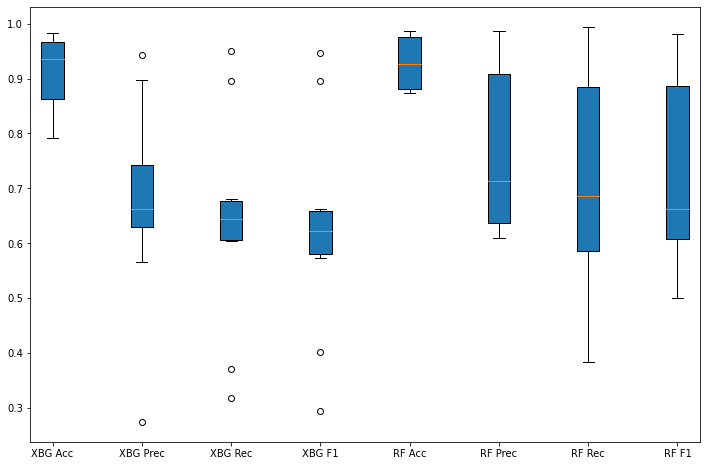

In [16]:
from matplotlib import pyplot
plt.figure(figsize=(12, 8))
box = plt.boxplot(res,patch_artist=True,
                  positions=[1,3,5,7,9,11,13,15],
                  labels=['XBG Acc','XBG Prec','XBG Rec' ,'XBG F1', 'RF Acc','RF Prec', 'RF Rec', 'RF F1'])

In [17]:
results_std

[0.06231,
 0.17445,
 0.18511,
 0.18463,
 0.0909,
 0.10807,
 0.06922,
 0.07579,
 0.04233,
 0.20005,
 0.192,
 0.20345,
 0.11803,
 0.09299,
 0.08165,
 0.08554,
 0.04662,
 0.14097,
 0.1964,
 0.16634,
 0.1136,
 0.17514,
 0.07481,
 0.08639]